# Performance of quantization on the RGB domain

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os

In [2]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int16)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

# Notice that, although this is a dead-zone quantizer, we are not going
# to work with negative samples, and therefore, the dead-zone
# does not have any effect.

In [3]:
def load_frame(prefix):
    fn = f"{prefix}.png"
    frame = cv2.imread(fn, cv2.IMREAD_UNCHANGED) # [rows, cols, comp]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = np.array(frame)
    frame = frame.astype(np.float32) - 32768.0
    frame = frame.astype(np.uint8)
    return frame

def write_frame(frame, prefix):
    frame = frame.astype(np.float32)
    frame += 32768.0
    frame = frame.astype(np.uint16)
    cv2.imwrite(f"{prefix}.png", frame)

In [4]:
def load_indexes(prefix):
    load_frame(prefix)
    
def write_indexes(prefix):
    write_frame(prefix)

In [6]:
fn = "/home/soloelectronicos/MRVC/sequences/stockholm/000"
frame = load_frame(fn)
print(frame.max(), frame.min())

255 0


In [7]:
def normalize(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    return (img-min_component)/max_min_component

def show_frame(frame, prefix):
    frame = normalize(frame)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=20)
    plt.imshow(frame)

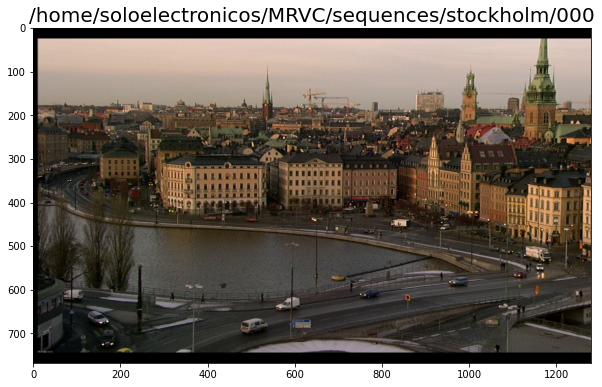

In [8]:
show_frame(frame, fn)

In [9]:
def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def MSE(x, y):
    error_signal = x - y
    return average_energy(error_signal)

def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(MSE(error_signal))

In [10]:
def bytes_per_frame(frame):
    write_frame(frame, "/tmp/frame")
    length_in_bytes = os.path.getsize("/tmp/frame.png")
    return length_in_bytes

def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

In [11]:
def RD_curve(x):
    points = []
    for q_step in range(0, 8):
        k, y = q_deq(x, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(x, y)
        points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return points

RD_points = RD_curve(frame)

q_step=  1, rate=2409744 bytes, distortion=   0.0
q_step=  2, rate=2020123 bytes, distortion=1773.4
q_step=  4, rate=1616819 bytes, distortion=12410.9
q_step=  8, rate=1226618 bytes, distortion=61573.7
q_step= 16, rate= 873581 bytes, distortion=272674.1
q_step= 32, rate= 569200 bytes, distortion=1112306.9
q_step= 64, rate= 319281 bytes, distortion=4760206.6
q_step=128, rate=  81184 bytes, distortion=12660496.0


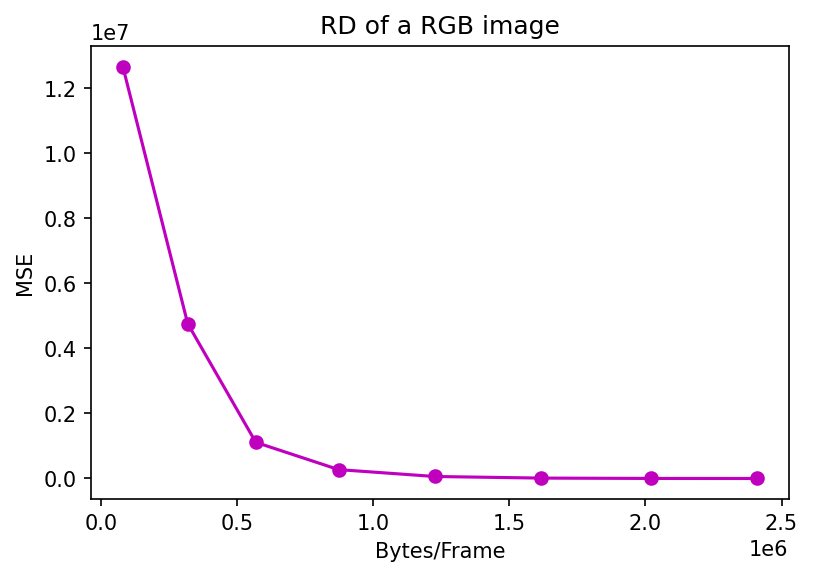

In [12]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker="o")
pylab.title("RD of a RGB image")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("MSE")
pylab.show()

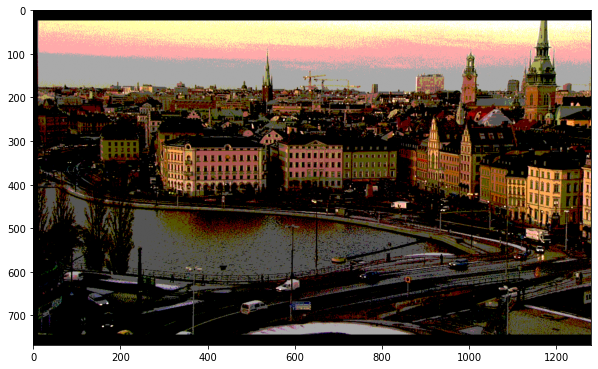

In [13]:
k, y = q_deq(frame, 64)
show_frame(y, "")

## RD curves of each channel

In [14]:
def only_R_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        R_frame = RGB_frame[:,:,0]
        dequantized_R_frame = np.empty_like(R_frame)
        k = np.empty_like(R_frame)
        k, dequantized_R_frame = q_deq(R_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(R_frame, dequantized_R_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

def only_G_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        G_frame = RGB_frame[:,:,1]
        dequantized_G_frame = np.empty_like(G_frame)
        k = np.empty_like(G_frame)
        k, dequantized_G_frame = q_deq(G_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(G_frame, dequantized_G_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

def only_B_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        B_frame = RGB_frame[:,:,2]
        dequantized_B_frame = np.empty_like(B_frame)
        k = np.empty_like(B_frame)
        k, dequantized_B_frame = q_deq(B_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(B_frame, dequantized_B_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

only_R_points = only_R_RD_curve(frame)
only_G_points = only_G_RD_curve(frame)
only_B_points = only_B_RD_curve(frame)

q_step=  1, rate= 807363 bytes, distortion=   0.0
q_step=  2, rate= 675610 bytes, distortion= 593.7
q_step=  4, rate= 544173 bytes, distortion=4163.2
q_step=  8, rate= 419926 bytes, distortion=20727.5
q_step= 16, rate= 295711 bytes, distortion=91792.4
q_step= 32, rate= 188683 bytes, distortion=380588.0
q_step= 64, rate= 110884 bytes, distortion=1583583.9
q_step=128, rate=  37613 bytes, distortion=5220482.3
q_step=  1, rate= 800541 bytes, distortion=   0.0
q_step=  2, rate= 668619 bytes, distortion= 594.4
q_step=  4, rate= 537487 bytes, distortion=4167.9
q_step=  8, rate= 413045 bytes, distortion=20515.5
q_step= 16, rate= 289226 bytes, distortion=91481.1
q_step= 32, rate= 183868 bytes, distortion=361696.4
q_step= 64, rate= 108346 bytes, distortion=1626303.6
q_step=128, rate=  28116 bytes, distortion=4285615.7
q_step=  1, rate= 800368 bytes, distortion=   0.0
q_step=  2, rate= 669284 bytes, distortion= 585.3
q_step=  4, rate= 538102 bytes, distortion=4079.8
q_step=  8, rate= 413514 bytes

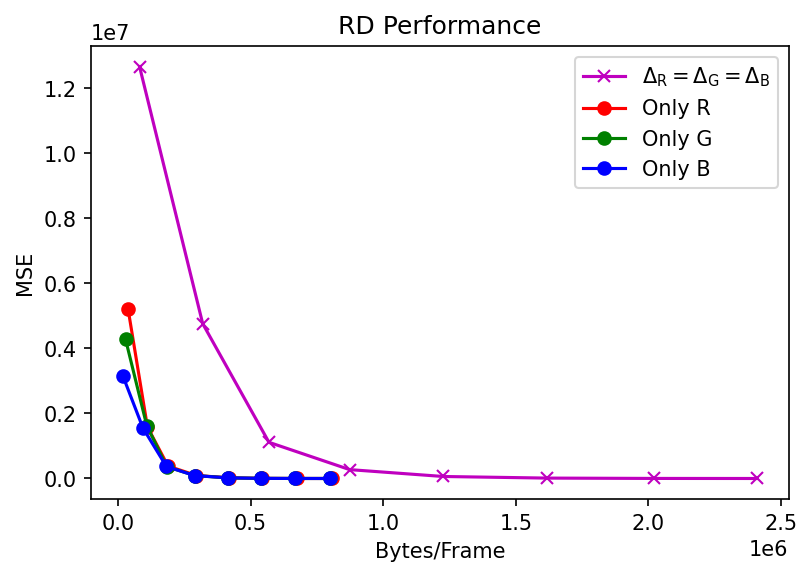

In [15]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker="x",
           label='$\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$')
pylab.plot(*zip(*only_R_points), c='r', marker="o",
           label='Only R')              
pylab.plot(*zip(*only_G_points), c='g', marker="o",
           label='Only G')              
pylab.plot(*zip(*only_B_points), c='b', marker="o",
           label='Only B')              
pylab.title("RD Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

The $\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$ quantization scheme is near optimal because the slope at the different quantization points is almost the same. This can be seen in the next experiment

## Testing a different quantization configuration

In [16]:
N = 6
def only_R_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<N)
        rate = bytes_per_frame(k)
        distortion = MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

def only_G_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<N)
        rate = bytes_per_frame(k)
        distortion = MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

def only_B_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

only_R_points = only_R_RD_curve(frame)
only_G_points = only_G_RD_curve(frame)
only_B_points = only_B_RD_curve(frame)

q_step=  1, rate=1385151 bytes, distortion=3176622.7
q_step=  2, rate=1218056 bytes, distortion=3177216.4
q_step=  4, rate=1024082 bytes, distortion=3180785.9
q_step=  8, rate= 801841 bytes, distortion=3197350.3
q_step= 16, rate= 589834 bytes, distortion=3268415.1
q_step= 32, rate= 422306 bytes, distortion=3557210.7
q_step= 64, rate= 319281 bytes, distortion=4760206.6
q_step=128, rate= 255178 bytes, distortion=8397105.0
q_step=  1, rate=1379004 bytes, distortion=3133903.0
q_step=  2, rate=1209048 bytes, distortion=3134497.4
q_step=  4, rate=1014231 bytes, distortion=3138071.0
q_step=  8, rate= 791187 bytes, distortion=3154418.5
q_step= 16, rate= 577716 bytes, distortion=3225384.2
q_step= 32, rate= 421790 bytes, distortion=3495599.5
q_step= 64, rate= 319281 bytes, distortion=4760206.6
q_step=128, rate= 257135 bytes, distortion=7419518.8
q_step=  1, rate=1386174 bytes, distortion=3209887.5
q_step=  2, rate=1217472 bytes, distortion=3210472.8
q_step=  4, rate=1022607 bytes, distortion=321

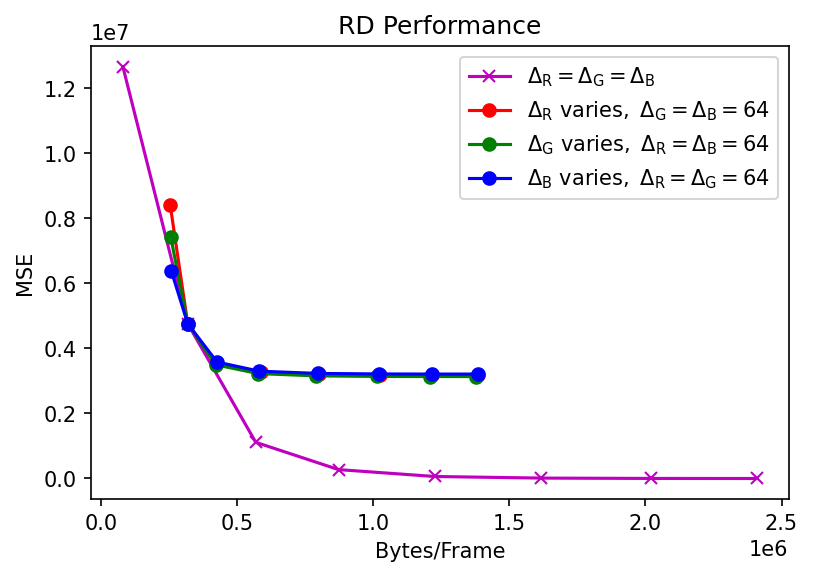

In [17]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker="x",
           label='$\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$')
pylab.plot(*zip(*only_R_points), c='r', marker="o",
           label='$\Delta_{\mathrm{R}}~\mathrm{varies},~\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_G_points), c='g', marker="o",
           label='$\Delta_{\mathrm{G}}~\mathrm{varies},~\Delta_{\mathrm{R}}=\Delta_{\mathrm{B}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_B_points), c='b', marker="o",
           label='$\Delta_{\mathrm{B}}~\mathrm{varies},~\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=$' + '{}'.format(1<<N))              
pylab.title("RD Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

As it can be seen, the best configuration matches $\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$.